Папка на GDrive:

https://drive.google.com/drive/folders/1FeUwrVfxp09xAifiMngwtfrRZ8nhtj8T?usp=sharing


In [1]:
from os import listdir

USE_GDRIVE = False


if USE_GDRIVE:
    from google.colab import drive
    drive.mount("/home/GDrive")
    DATA_PATH = f"/home/GDrive/MyDrive/made_2021_fraud_project/data"
else:
    DATA_PATH = "../../data"

GPS_PATH = "../../data/gps_data.csv"
ACCEL_PATH = "../../data/accel_data.csv"

listdir(DATA_PATH)

['drivers_stats.csv',
 'gps_data.csv',
 'unlabeled',
 'good_data',
 'points_stats.csv',
 'all_gps.csv',
 'all_accel.csv',
 'accel_data.csv',
 'drivers_with_gps_and_sl_problems',
 'gps_stats.csv',
 'rides_of_drivers.csv',
 'accel_stats.csv']

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import folium
from haversine import haversine, Unit
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline

In [3]:
from math import radians, cos, sin, asin, sqrt

def haversine_approx(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # haversine formula 
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    meters = km * 1000
    return meters

# ЧЛБ - ЕКБ = 193 km
haversine_approx(55.159812, 61.402416, 56.839103, 60.593395)

193261.08011876777

In [4]:
def euclid_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    dist = np.sqrt(dlon**2 + dlat**2)
    return dist

euclid_distance(55.159812, 61.402416, 56.839103, 60.593395)

0.03253311160761813

In [5]:
def describe(df):
    display(pd.concat((df.dtypes, df.describe(datetime_is_numeric=True).T), axis=1))
    display(df.shape)

In [6]:
df_accel = pd.read_csv(ACCEL_PATH, parse_dates=[0]).sort_values(by="time")
describe(df_accel)

,0,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],2172989,2020-11-22 15:27:12.714646016,2015-03-01 05:46:42.832594,2020-12-18 06:53:34.205120,2021-03-18 16:54:00.549220096,2021-06-12 11:02:18.664983040,2021-08-29 00:03:16.287344,NaN
x,float64,2.17299e+06,0.368934,-71.1054,-0.371101,0.184359,0.785298,65.1529,2.36914
y,float64,2.17299e+06,7.6569,-74.7916,7.63271,8.85376,9.50019,55.2294,3.4034
z,float64,2.17299e+06,3.83295,-65.5062,2.01402,3.69992,5.35365,76.4756,2.73072
lat,float64,2.17299e+06,55.7482,55.3163,55.6768,55.7512,55.8214,82.4343,0.16893
lon,float64,2.17299e+06,37.601,36.3143,37.5016,37.5863,37.686,108.856,0.376061
driver_hash,int64,2.17299e+06,-1.12657e+17,-9.21858e+18,-4.47912e+18,-4.14168e+17,4.43147e+18,9.20647e+18,5.3536e+18
fraud,int64,2.17299e+06,-0.796897,-1,-1,-1,-1,1,0.509161


(2172989, 8)

In [7]:
df_accel["time_diff"] = df_accel["time"].sort_values().diff().dt.total_seconds()
df_accel["time_diff"].fillna(0.0, inplace=True)
describe(df_accel[["time_diff"]])

,0,count,mean,std,min,25%,50%,75%,max
time_diff,float64,2172989.0,94.343134,30867.077948,0.0,0.000547,0.000772,0.001919,2.209495e+07


(2172989, 1)

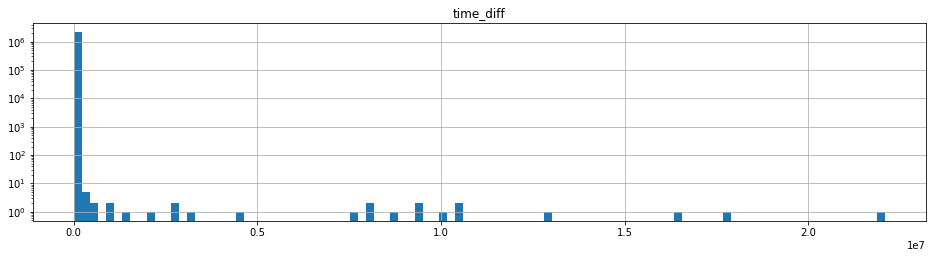

In [8]:
plt.figure(figsize=(16,8))

plt.subplot(212)
df_accel["time_diff"].hist(bins=100)
plt.yscale("log")
plt.title("time_diff")

plt.show()

In [9]:
euclid_v = np.vectorize(euclid_distance)

df_accel["euclid"] = euclid_v(df_accel['lat'], df_accel['lon'], df_accel['lat'].shift(), df_accel['lon'].shift())
df_accel["euclid"].describe()

count    2.172988e+06
mean     1.474371e-04
std      1.542595e-03
min      0.000000e+00
25%      2.430962e-07
50%      4.260105e-06
75%      1.185707e-05
max      1.329890e+00
Name: euclid, dtype: float64

In [10]:
df_accel["euclid"] /= df_accel["euclid"].mean()
df_accel["euclid"].describe()

count    2.172988e+06
mean     1.000000e+00
std      1.046273e+01
min      0.000000e+00
25%      1.648813e-03
50%      2.889439e-02
75%      8.042121e-02
max      9.020049e+03
Name: euclid, dtype: float64

In [11]:
haversine_v = np.vectorize(haversine_approx)

df_accel["distance"] = haversine_v(df_accel['lat'], df_accel['lon'], df_accel['lat'].shift(), df_accel['lon'].shift())
df_accel["distance"].describe()

count    2.172988e+06
mean     7.043176e+02
std      5.402181e+03
min      0.000000e+00
25%      1.130026e+00
50%      1.993011e+01
75%      5.381984e+01
max      3.605181e+06
Name: distance, dtype: float64

In [12]:
df_accel["distance"] = df_accel["distance"].clip(None, 10000)
df_accel["distance"].describe()

count    2.172988e+06
mean     3.496731e+02
std      1.684924e+03
min      0.000000e+00
25%      1.130026e+00
50%      1.993011e+01
75%      5.381984e+01
max      1.000000e+04
Name: distance, dtype: float64

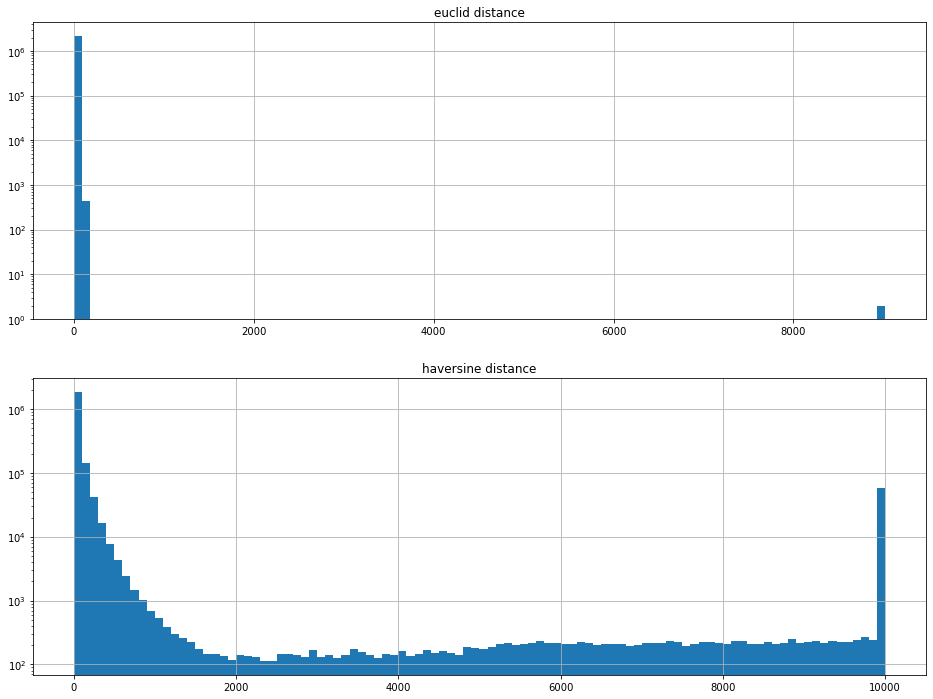

In [13]:
plt.figure(figsize=(16,12))

plt.subplot(211)
df_accel["euclid"].hist(bins=100)
plt.yscale("log")
plt.title("euclid distance")

plt.subplot(212)
df_accel["distance"].hist(bins=100)
plt.yscale("log")
plt.title("haversine distance")

plt.show()

In [14]:
df_accel["time_chord_speed"] = df_accel["euclid"] / df_accel["time_diff"]
df_accel["time_chord_speed"] = df_accel["time_chord_speed"].fillna(0.0).replace(np.inf, 0.0)

df_accel["time_speed"] = df_accel["distance"] / df_accel["time_diff"]
df_accel["time_speed"] = df_accel["time_speed"].fillna(0.0).replace(np.inf, 0.0)

describe(df_accel[["time_speed", "time_chord_speed"]])

,0,count,mean,std,min,25%,50%,75%,max
time_speed,float64,2172989.0,46960.161555,7.437457e+06,0.0,201.875268,13903.945903,51407.499026,1.000000e+10
time_chord_speed,float64,2172989.0,100.234093,2.521782e+04,0.0,0.299484,20.289695,75.176983,3.364727e+07


(2172989, 2)

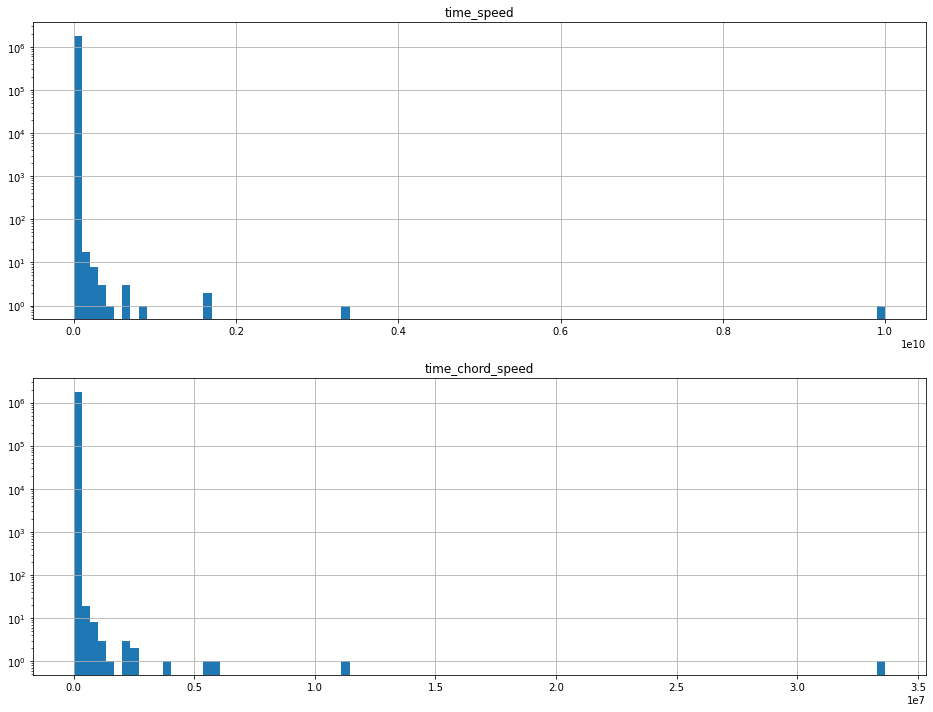

In [15]:
plt.figure(figsize=(16,12))

plt.subplot(211)
df_accel["time_speed"][df_accel["time_speed"].round(0) > 0.0].hist(bins=100)
plt.yscale("log")
plt.title("time_speed")

plt.subplot(212)
df_accel["time_chord_speed"][df_accel["time_speed"].round(0) > 0.0].hist(bins=100)
plt.yscale("log")
plt.title("time_chord_speed")

plt.show()

In [16]:
describe(df_accel)

,0,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],2172989,2020-11-22 15:27:12.714646016,2015-03-01 05:46:42.832594,2020-12-18 06:53:34.205120,2021-03-18 16:54:00.549220096,2021-06-12 11:02:18.664983040,2021-08-29 00:03:16.287344,NaN
x,float64,2.17299e+06,0.368934,-71.1054,-0.371101,0.184359,0.785298,65.1529,2.36914
y,float64,2.17299e+06,7.6569,-74.7916,7.63271,8.85376,9.50019,55.2294,3.4034
z,float64,2.17299e+06,3.83295,-65.5062,2.01402,3.69992,5.35365,76.4756,2.73072
lat,float64,2.17299e+06,55.7482,55.3163,55.6768,55.7512,55.8214,82.4343,0.16893
lon,float64,2.17299e+06,37.601,36.3143,37.5016,37.5863,37.686,108.856,0.376061
driver_hash,int64,2.17299e+06,-1.12657e+17,-9.21858e+18,-4.47912e+18,-4.14168e+17,4.43147e+18,9.20647e+18,5.3536e+18
fraud,int64,2.17299e+06,-0.796897,-1,-1,-1,-1,1,0.509161
time_diff,float64,2.17299e+06,94.3431,0,0.000547,0.000772,0.001919,2.20949e+07,30867.1
euclid,float64,2.17299e+06,1,0,0.00164881,0.0288944,0.0804212,9020.05,10.4627


(2172989, 13)

In [17]:
def map_driver_routs(driver_hash, df=df_accel, min_points=10):
    driver_accel = df[df["driver_hash"] == driver_hash]
    center = (driver_accel["lat"].mean(), driver_accel["lon"].mean())
    m = folium.Map(location=center, zoom_start=10, legend=True)
    
    idx_column = "route_by_time"
    route_ids = driver_accel[idx_column].unique()
    cmap = list(colors.XKCD_COLORS.values())
    legend = '<span style="color: {col};">by_time_{txt}_({num})</span>'
    
    for i, idx in enumerate(route_ids):
        route_accel = driver_accel[driver_accel[idx_column] == idx]
        if route_accel.shape[0] < min_points:
            continue
            
        color = cmap[np.random.choice(len(cmap))]
        name = legend.format(txt=idx, col=color, num=route_accel.shape[0])
        fg = folium.FeatureGroup(name).add_to(m)
        folium.PolyLine(route_accel[["lat", "lon"]], color=color, weight=6, opacity=0.8).add_to(fg)

    folium.map.LayerControl('topleft', collapsed= False).add_to(m)
    return m

In [20]:
# [1, 0, -1, None]
FORCE_FRAUD = None

if not FORCE_FRAUD is None:
    cur_driver = np.random.choice(df_accel.loc[df_gps["fraud"] == FORCE_FRAUD, "driver_hash"].unique())
else:
    cur_driver = np.random.choice(df_accel["driver_hash"].unique())

# пример водителя в большим количесвтом сматченных точек
# cur_driver = -6646726793274239750

fraud = df_accel.loc[df_accel["driver_hash"] == cur_driver,"fraud"].values[0]
display(f"Current Driver: {cur_driver} [fraud={fraud}]")

'Current Driver: -8125896513185457909 [fraud=-1]'

In [21]:
df_accel["route_by_time"] = df_accel["time"].diff().dt.round("300s").cumsum().dt.seconds
num_routes = len(df_accel["route_by_time"].unique())
display(f"Number of routes by time: {num_routes}")

map_driver_routs(cur_driver)

'Number of routes by time: 289'

In [29]:
X = df_accel[[
    "x",
    "y",
    "z",
    "time_diff",
    "euclid",
    "distance",
    "time_chord_speed",
    "time_speed"
]].copy().replace(np.nan, 0.0)

# X["sin_x"] = np.sin(X["x"])
# X["cos_x"] = np.cos(X["x"])
# X["sin_y"] = np.sin(X["y"])
# X["cos_y"] = np.cos(X["y"])
# X["sin_z"] = np.sin(X["z"])
# X["cos_z"] = np.cos(X["z"])

# X["sum_x"] = np.cumsum(X["x"])
# X["sum_y"] = np.cumsum(X["y"])
# X["sum_z"] = np.cumsum(X["z"])

# X["sum_sin_x"] = np.cumsum(X["sin_x"])
# X["sum_cos_x"] = np.cumsum(X["cos_x"])
# X["sum_sin_y"] = np.cumsum(X["sin_y"])
# X["sum_cos_y"] = np.cumsum(X["cos_y"])
# X["sum_sin_z"] = np.cumsum(X["sin_z"])
# X["sum_cos_z"] = np.cumsum(X["cos_z"])

for col in X.columns:
    X[col] -= X[col].min()
    X[col] /= X[col].max()

X["sin_x"] = np.sin(X["x"])
X["cos_x"] = np.cos(X["x"])
X["sin_y"] = np.sin(X["y"])
X["cos_y"] = np.cos(X["y"])
X["sin_z"] = np.sin(X["z"])
X["cos_z"] = np.cos(X["z"])

X["sum_x"] = np.cumsum(X["x"])
X["sum_y"] = np.cumsum(X["y"])
X["sum_z"] = np.cumsum(X["z"])

X["sum_sin_x"] = np.cumsum(X["sin_x"])
X["sum_cos_x"] = np.cumsum(X["cos_x"])
X["sum_sin_y"] = np.cumsum(X["sin_y"])
X["sum_cos_y"] = np.cumsum(X["cos_y"])
X["sum_sin_z"] = np.cumsum(X["sin_z"])
X["sum_cos_z"] = np.cumsum(X["cos_z"])

describe(X)

pca = PCA(n_components=2)
df_accel.loc[:,["pca_x","pca_y"]] = pca.fit_transform(X)

,0,count,mean,std,min,25%,50%,75%,max
x,float64,2172989.0,0.524550,0.017387,0.000000,5.191192e-01,5.231958e-01,5.276061e-01,1.000000e+00
y,float64,2172989.0,0.634117,0.026176,0.000000,6.339306e-01,6.433218e-01,6.482935e-01,1.000000e+00
z,float64,2172989.0,0.488367,0.019233,0.000000,4.755557e-01,4.874297e-01,4.990772e-01,1.000000e+00
time_diff,float64,2172989.0,0.000004,0.001397,0.000000,2.475679e-11,3.494012e-11,8.685245e-11,1.000000e+00
euclid,float64,2172989.0,0.000111,0.001160,0.000000,1.827943e-07,3.203352e-06,8.915829e-06,1.000000e+00
distance,float64,2172989.0,0.034967,0.168492,0.000000,1.130004e-04,1.993010e-03,5.381978e-03,1.000000e+00
time_chord_speed,float64,2172989.0,0.000003,0.000749,0.000000,8.900697e-09,6.030116e-07,2.234267e-06,1.000000e+00
time_speed,float64,2172989.0,0.000005,0.000744,0.000000,2.018753e-08,1.390395e-06,5.140750e-06,1.000000e+00
sin_x,float64,2172989.0,0.500747,0.014959,0.000000,4.961156e-01,4.996509e-01,5.034664e-01,8.414710e-01
cos_x,float64,2172989.0,0.865419,0.008854,0.540302,8.640148e-01,8.662268e-01,8.682565e-01,1.000000e+00


(2172989, 23)

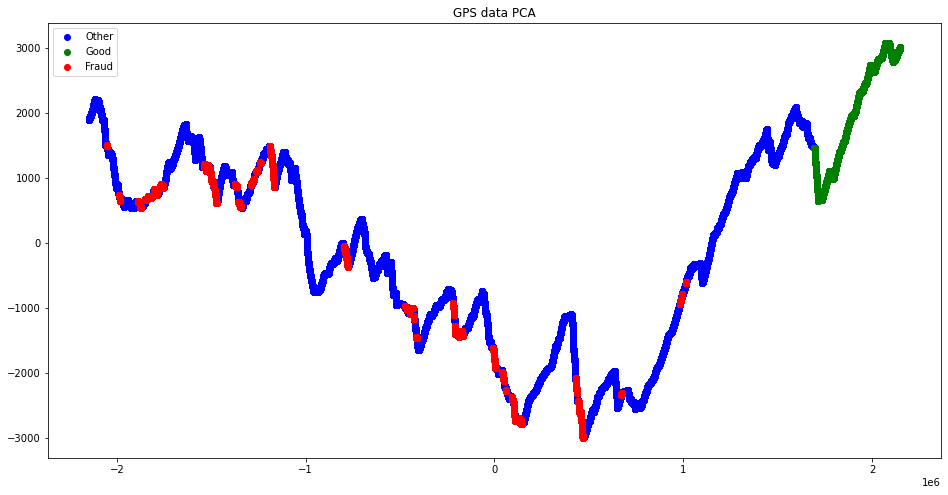

In [30]:
plt.figure(figsize=(16,8))

df_other = df_accel[df_accel["fraud"] == -1]
plt.scatter(df_other["pca_x"], df_other["pca_y"], color="blue", label="Other")

df_proper = df_accel[df_accel["fraud"] == 0]
plt.scatter(df_proper["pca_x"], df_proper["pca_y"], color="green", label="Good")

df_fraud = df_accel[df_accel["fraud"] == 1]
plt.scatter(df_fraud["pca_x"], df_fraud["pca_y"], color="red", label="Fraud")

plt.legend()
plt.title("GPS data PCA")
plt.show()

In [31]:
X = df_accel[[
    "x",
    "y",
    "z",
    "time_diff",
    "euclid",
    "distance",
    "time_chord_speed",
    "time_speed"
]].copy().replace(np.nan, 0.0)

X["sin_x"] = np.sin(X["x"])
X["cos_x"] = np.cos(X["x"])
X["sin_y"] = np.sin(X["y"])
X["cos_y"] = np.cos(X["y"])
X["sin_z"] = np.sin(X["z"])
X["cos_z"] = np.cos(X["z"])

X["sum_x"] = np.cumsum(X["x"])
X["sum_y"] = np.cumsum(X["y"])
X["sum_z"] = np.cumsum(X["z"])

X["sum_sin_x"] = np.cumsum(X["sin_x"])
X["sum_cos_x"] = np.cumsum(X["cos_x"])
X["sum_sin_y"] = np.cumsum(X["sin_y"])
X["sum_cos_y"] = np.cumsum(X["cos_y"])
X["sum_sin_z"] = np.cumsum(X["sin_z"])
X["sum_cos_z"] = np.cumsum(X["cos_z"])

for col in X.columns:
    X[col] -= X[col].min()
    X[col] /= X[col].max()

describe(X)

pca = PCA(n_components=2)
df_accel.loc[:,["pca_x","pca_y"]] = pca.fit_transform(X)

,0,count,mean,std,min,25%,50%,75%,max
x,float64,2172989.0,0.524550,0.017387,0.0,5.191192e-01,5.231958e-01,5.276061e-01,1.0
y,float64,2172989.0,0.634117,0.026176,0.0,6.339306e-01,6.433218e-01,6.482935e-01,1.0
z,float64,2172989.0,0.488367,0.019233,0.0,4.755557e-01,4.874297e-01,4.990772e-01,1.0
time_diff,float64,2172989.0,0.000004,0.001397,0.0,2.475679e-11,3.494012e-11,8.685245e-11,1.0
euclid,float64,2172989.0,0.000111,0.001160,0.0,1.827943e-07,3.203352e-06,8.915829e-06,1.0
distance,float64,2172989.0,0.034967,0.168492,0.0,1.130004e-04,1.993010e-03,5.381978e-03,1.0
time_chord_speed,float64,2172989.0,0.000003,0.000749,0.0,8.900697e-09,6.030116e-07,2.234267e-06,1.0
time_speed,float64,2172989.0,0.000005,0.000744,0.0,2.018753e-08,1.390395e-06,5.140750e-06,1.0
sin_x,float64,2172989.0,0.550989,0.295349,0.0,3.230098e-01,5.703303e-01,8.011721e-01,1.0
cos_x,float64,2172989.0,0.784909,0.281063,0.0,7.003685e-01,9.153291e-01,9.833778e-01,1.0


(2172989, 23)

/home/dm/miniconda3/envs/made-fraud/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


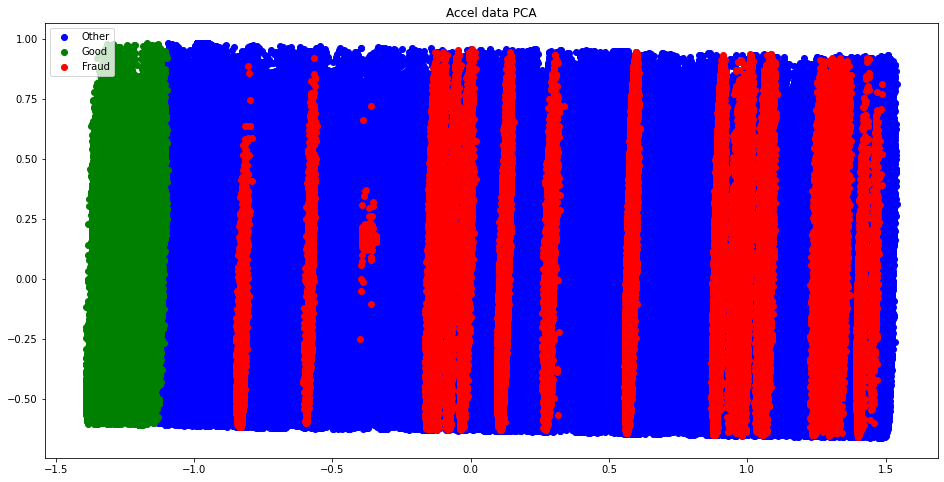

In [32]:
plt.figure(figsize=(16,8))

df_other = df_accel[df_accel["fraud"] == -1]
plt.scatter(df_other["pca_x"], df_other["pca_y"], color="blue", label="Other")

df_proper = df_accel[df_accel["fraud"] == 0]
plt.scatter(df_proper["pca_x"], df_proper["pca_y"], color="green", label="Good")

df_fraud = df_accel[df_accel["fraud"] == 1]
plt.scatter(df_fraud["pca_x"], df_fraud["pca_y"], color="red", label="Fraud")

plt.legend()
plt.title("Accel data PCA")
plt.show()